In [ ]:
%pip install snntorch

In [ ]:
%pip install torchvision

In [3]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
import torch

import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
# @title plotting settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=2.25):

    fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True,
                                            gridspec_kw={'height_ratios': [1, 1, 0.4]})
    # plot input current
    ax[0].plot(cur, c = "tab:orange")
    ax[0].set_ylim([0, ylim_max1])
    ax[0].set_xlim([0, 200])
    ax[0].set_ylabel("input current (I_in)")

    if title:
        ax[0].set_title(title)

    ax[1].plot(mem)
    ax[1].set_ylim([0, ylim_max2])
    ax[1].set_ylabel("Membrane Potential (U_mem)")
    if thr_line:
        ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

    plt.xlabel("Time step")

    splt.raster(spk, ax[2], s=400, c="black", marker="|")
    if vline:
        ax[2].axvline(x=vline, ymin=0, ymax=6.75, linestyle="dashed", c="black", linewidth=2, zorder=0,clip_on=False)
    plt.ylabel("Output spikes")
    plt.yticks([])

    plt.show()

In [3]:
lif = snn.Leaky(beta=0.8)

In [4]:
steps = 200

x = torch.cat((torch.zeros(10) , torch.ones(190) * 0.21))
mem = torch.zeros(1)
spk = torch.zeros(1)

In [5]:
mem_rec = []
spk_rec = []

for step in range(steps):
    spk, mem = lif(x[step], mem)

    mem_rec.append(mem)
    spk_rec.append(spk)

mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

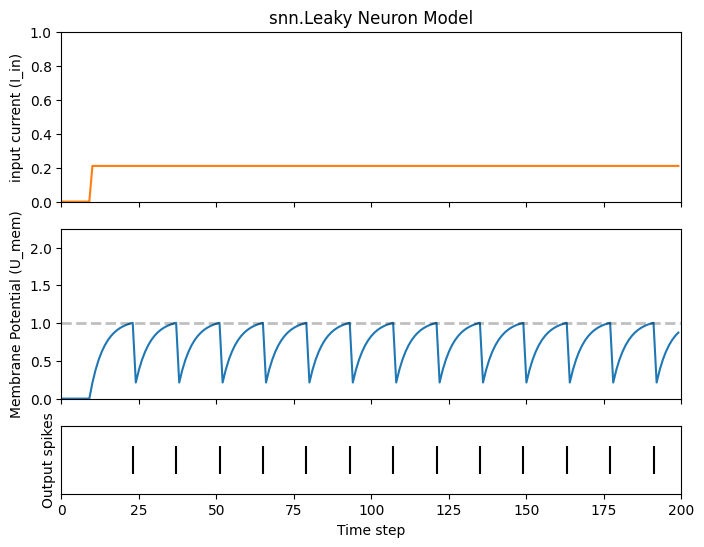

In [6]:
plot_cur_mem_spk(x, mem_rec, spk_rec, thr_line=1, ylim_max1=1.0, title="snn.Leaky Neuron Model")

In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools

In [8]:
# dataloader arguments

batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0, ), (1, ))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 96292007.60it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31661185.00it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26672109.92it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10079644.85it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [10]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
# network architecture.
n_inputs = 784
n_hidden = 1000
n_outputs = 10

# temporal dynamics.
n_steps = 25
beta = 0.95

In [12]:
from snntorch import surrogate

class Net(nn.Module):
    def __init__(self):

        super().__init__()

        # define a single beta for each neuron in the excitation layer.
        # beta1 = torch.randn(n_hidden)
        # self.lif1 = snn.Leaky(beta=beta1, learn_beta=True)

        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=1.0)

        self.fc2 = nn.Linear(n_hidden, n_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=1.0)

    def forward(self, x):

        # initialize the hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # record the final layer.
        spk2_rec = []
        mem2_rec = []

        # time-loop.
        for step in range(n_steps):
            current_1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(current_1, mem1)
            current_2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(current_2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0) # time_steps x batch x n_outputs

net = Net().to(device)

In [13]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

n_epochs = 1
counter = 0

loss_hist = []

for epoch in range(n_epochs):

    train_batch = iter(train_loader)

    for data, targets in train_batch:

        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net(data)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        loss_hist.append(loss_val.item())

        if counter % 10  == 0:
            print(f"iteration: {counter} \t Train loss: {loss_val.item()}")

        counter += 1

        if counter == 100:
            break

iteration: 0 	 Train loss: 2.4857146739959717
iteration: 10 	 Train loss: 1.0972648859024048
iteration: 20 	 Train loss: 0.6996682286262512
iteration: 30 	 Train loss: 0.6449530124664307
iteration: 40 	 Train loss: 0.4721190631389618
iteration: 50 	 Train loss: 0.4611121118068695
iteration: 60 	 Train loss: 0.38107770681381226
iteration: 70 	 Train loss: 0.2290082424879074
iteration: 80 	 Train loss: 0.19889354705810547
iteration: 90 	 Train loss: 0.2101992815732956


In [14]:
def measure_accuracy(model, dataloader):

    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
        data = data.to(device)
        targets = targets.to(device)

        spk_rec, _ = model(data)
        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)

        n_correct = (max_spike == targets).sum()

        running_length += len(targets)
        running_accuracy += n_correct

    accuracy = running_accuracy / running_length

    return accuracy.item()

In [15]:
measure_accuracy(net, test_loader)

0.9329928159713745

### Convolutional SNN Classifier

In [16]:
# network class.

class Convnet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 8, 5, padding='same')
        self.lif1 = snn.Leaky(beta = beta)
        self.mp1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(8, 24, 5, padding='same')
        self.lif2 = snn.Leaky(beta=beta)
        self.mp2 = nn.MaxPool2d(2)

        self.fc = nn.Linear(24 * 7 * 7, 10)
        self.lif3 = snn.Leaky(beta = beta)

    def forward(self, x):

        # initialize the hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # record the final layer.
        spk3_rec = []
        mem3_rec = []

        # time-loop.
        for step in range(n_steps):
            current_1 = self.conv1(x)
            spk1, mem1 = self.lif1(self.mp1(current_1), mem1)
            current_2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(self.mp2(current_2), mem2)

            spk3, mem3 = self.lif3(self.fc(spk2.flatten(1)), mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0) # time_steps x batch x n_outputs

conv_net = Convnet().to(device)

In [17]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_net.parameters(), lr=1e-2, betas=(0.9, 0.999))

n_epochs = 1
counter = 0

loss_hist = []

for epoch in range(n_epochs):

    train_batch = iter(train_loader)

    for data, targets in train_batch:

        data = data.to(device)
        targets = targets.to(device)

        conv_net.train()
        spk_rec, _ = conv_net(data)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        loss_hist.append(loss_val.item())

        if counter % 10  == 0:
            print(f"iteration: {counter} \t Train loss: {loss_val.item()}")

        counter += 1

        if counter == 100:
            break

iteration: 0 	 Train loss: 2.3158323764801025
iteration: 10 	 Train loss: 2.3025853633880615
iteration: 20 	 Train loss: 2.3025853633880615
iteration: 30 	 Train loss: 1.9528366327285767
iteration: 40 	 Train loss: 0.9574185609817505
iteration: 50 	 Train loss: 0.8988001346588135
iteration: 60 	 Train loss: 0.43195009231567383
iteration: 70 	 Train loss: 0.1964796781539917
iteration: 80 	 Train loss: 0.39373263716697693
iteration: 90 	 Train loss: 0.33110448718070984


In [18]:
def measure_accuracy(model, dataloader):

    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
        data = data.to(device)
        targets = targets.to(device)

        spk_rec, _ = model(data)
        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)

        n_correct = (max_spike == targets).sum()

        running_length += len(targets)
        running_accuracy += n_correct

    accuracy = running_accuracy / running_length

    return accuracy.item()

In [19]:
measure_accuracy(conv_net, test_loader)

0.9164663553237915

In [ ]:
class Net(nn.Module):
    def __init__(self):

        super().__init__()
        n_steps = 1

        n_outputs = 10
        population = 100

        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(n_hidden, n_outputs * population)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(n_steps):
            current_1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(current_1, mem1)
            current_2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(current_2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

pop_net = Net().to(device)

In [ ]:
from snntorch import functional as SF

In [22]:
loss_function = SF.ce_count_loss(population_code=True, num_classes=10)
optimizer = torch.optim.Adam(pop_net.parameters(), lr=1e-3, betas=(0.9, 0.999))


n_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

for epoch in range(n_epochs):

    train_batch = iter(train_loader)

    for data, targets in train_batch:

        data = data.to(device)
        targets = targets.to(device)

        pop_net.train()
        spk_rec, _ = pop_net(data)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        loss_hist.append(loss_val.item())

        if counter % 10  == 0:
            print(f"iteration: {counter} \t Train loss: {loss_val.item()}")

        counter += 1

        if counter == 100:
            break

iteration: 0 	 Train loss: 7.150913238525391
iteration: 10 	 Train loss: 0.8922330737113953
iteration: 20 	 Train loss: 0.7252842783927917
iteration: 30 	 Train loss: 0.4287715256214142
iteration: 40 	 Train loss: 0.2534106969833374
iteration: 50 	 Train loss: 0.30166903138160706
iteration: 60 	 Train loss: 0.18730475008487701
iteration: 70 	 Train loss: 0.2740863263607025
iteration: 80 	 Train loss: 0.17299333214759827
iteration: 90 	 Train loss: 0.16341809928417206


In [23]:
def  population_acc(testloader, model):

    with torch.no_grad():
        model.eval()
        running_accuracy = 0
        running_length = 0

        for data, targets in iter(testloader):
            data = data.to(device)
            targets = targets.to(device)

            spk_rec, _ = model(data)
            running_accuracy += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=10)
            running_length += len(targets)

        accuracy = running_accuracy  * 100/ running_length

        return accuracy.item()

In [24]:
population_acc(test_loader, pop_net)

0.07652869591346154

### Recurrent Spiking Neural Networks

In [25]:
%pip install tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.7 MB/s eta 0:00:00


  0%|          | 0/700096 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_train.tar.gz to ./data/POKERDVS


  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_test.tar.gz to ./data/POKERDVS
[(    0, 20, 21, 0) (  106, 21, 19, 0) (  146, 13,  9, 1) ...
 (15365, 13, 17, 1) (15384, 16, 16, 1) (15408, 16, 22, 0)]


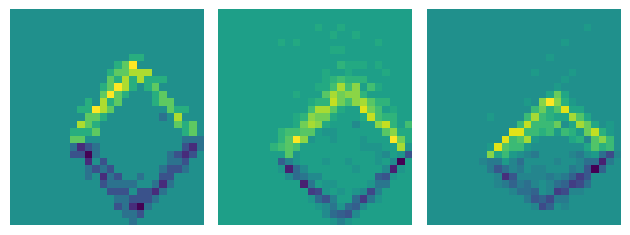

In [26]:
import tonic

dataset = tonic.datasets.POKERDVS(save_to='./data', train=True)
testset = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, targets = dataset[0]
print(events)
tonic.utils.plot_event_grid(events)

In [27]:
tonic.datasets.POKERDVS.sensor_size

(35, 35, 2)

In [28]:
import torchvision
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                            tonic.transforms.ToFrame(
                                                sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                                time_window=1000)])

batch_size = 8
cached_trainset = DiskCachedDataset(dataset, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(dataset, transform=frame_transform, cache_path='./cache/pokerdvs/test')

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

In [29]:
for data, labels in iter(train_loader):
    print(data.size())
    print(labels)

torch.Size([28, 8, 2, 35, 35])
tensor([1, 0, 3, 3, 2, 0, 1, 1])
torch.Size([25, 8, 2, 35, 35])
tensor([1, 0, 3, 2, 3, 3, 1, 2])
torch.Size([29, 8, 2, 35, 35])
tensor([2, 0, 1, 2, 0, 1, 0, 3])
torch.Size([24, 8, 2, 35, 35])
tensor([1, 0, 2, 3, 3, 3, 2, 0])
torch.Size([23, 8, 2, 35, 35])
tensor([1, 2, 3, 1, 2, 0, 0, 3])
torch.Size([26, 8, 2, 35, 35])
tensor([0, 2, 1, 1, 2, 2, 3, 0])


In [30]:
def dvs_animator(spike_data):
    fig, ax = plt.subplots()
    anim = splt.animator((spike_data[:, 0] + spike_data[:, 1]), fig, ax)
    return anim

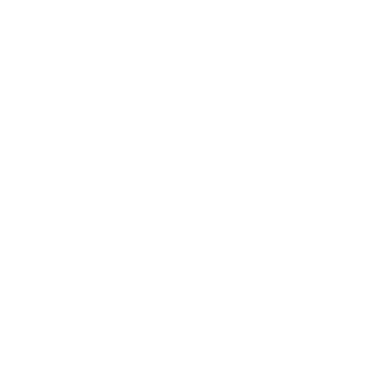

In [31]:
animation = dvs_animator(data[:, 1])
HTML(animation.to_html5_video())

In [32]:
class RSNN(nn.Module):

    def __init__(self):
        super().__init__()

        n_inputs = 35 * 35 * 2
        n_hidden = 512
        n_outputs = 4
        beta = 0.9

        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.lif1 = snn.RLeaky(beta=beta, linear_features=n_hidden)

        self.fc2 = nn.Linear(n_hidden, n_outputs)
        self.lif2 = snn.RLeaky(beta=beta, linear_features=n_outputs)

    def forward(self, x):

        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(x.size(0)):
            current_1 = self.fc1(x[step].flatten(1))
            spk1, mem1 = self.lif1(current_1, spk1, mem1)
            current_2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(current_2, spk2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

rnet = RSNN().to(device)

In [34]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnet.parameters(), lr=1e-3, betas=(0.9, 0.999))

n_epochs = 1
counter = 0

loss_hist = []

for epoch in range(n_epochs):

    train_batch = iter(train_loader)

    for data, targets in train_batch:

        data = data.to(device)
        targets = targets.to(device)

        rnet.train()
        spk_rec, _ = rnet(data)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        loss_hist.append(loss_val.item())

        if counter % 10  == 0:
            print(f"iteration: {counter} \t Train loss: {loss_val.item()}")

        counter += 1

        if counter == 100:
            break

iteration: 0 	 Train loss: 1.4734567403793335
